# Project 2 - Adaptive Monte Carlo Method

## Integration Problem

下面的代码用于解决积分问题：
$$
\mathrm { I } = \int _ { 0 } ^ { 1 } h(x) \mathrm { dx }
$$

测试函数为：

$$
h(x) = \pi \sin(\pi x)
$$

In [77]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat

def obj_fun(x):
    return np.pi * np.sin(np.pi * x)

## Naive Monte Carlo

### 积分程序

In [63]:
# Naive Monte Carlo
# input:
# -- obj_fun: function to integrate
# -- times: num of random samples
# output:
# -- I: Estimate of integration
# -- sigma2: sample variance
def MC_Int(obj_fun, times):
    I = 0
    Sigma = 0
    X = np.random.rand(times)
    for i in range(times):
        f_val = obj_fun(X[i])
        I += f_val
        Sigma += f_val**2
    I /= times
    return I, (Sigma - times*(I**2))/((times-1)*times)

### 测试结果

抽样次数为 $5 \times 10^5$。

In [71]:
MC_Int(obj_fun, times = 500000)

(1.9994652133113868, 1.867464200606012e-06)

## Adaptive Importance Sampling

### 积分程序

In [65]:
# for updating cut of intervals
# input:
# -- cut: origin cut of intervals
# -- m_cut: sum of |h(x)| in each interval
# -- K: parameter for cutting
# output:
# -- new_cut: new cut of intervals
def cut_update(cut, m_cut, K):
    
    # num of intervals
    N = len(cut) - 1
    # new cut
    new_cut = np.zeros(N+1)
    # compute m[i]
    m = m_cut
    for i in range(N):
        m[i] = m_cut[i] * (cut[i+1] - cut[i])
    m = m / sum(m)
    m = (K*m).astype(np.int) + 1
    
    # num of intervals to combine
    comb = (sum(m)/N).astype(np.int) + 1
    # count for num of combined intervals
    count = 1
    # current index in uncombined intervals
    index = 0
    # current position in uncombined intervals
    pos = 0.0
    # combine intervals
    for i in range(N):
        # length of small interval
        incre = (cut[i+1] - cut[i]) / m[i]
        for j in range(m[i]):
            index += 1
            pos += incre
            if(index == comb):
                new_cut[count] = pos
                count += 1
                index = 0
    new_cut[N] = 1
    return new_cut

# Adaptive Importance Sampling
# input:
# -- obj_fun: function to integrate
# -- n_sample: num of random samples in each iteration
# -- n_iter: num of iterations
# -- N: num of intervals to divide
# -- K: parameter for dividing intervals
# output:
# -- I: Estimate of integration
# -- sigma2: sample variance
def AIS_Int(obj_fun, n_sample, n_iter, N, K):

    # initial cut of [0, 1]
    cut = np.linspace(0, N, N+1) / N
    # estimate of each iteration
    I = np.zeros(n_iter)
    # sample variance of each iteration
    sigma2 = np.zeros(n_iter)

    for k in range(n_iter):
        # uniform random number on [0, 1]
        U = np.random.rand(n_sample)
        # decide which interval to locale
        W = np.random.randint(low = 0, high = N, size = n_sample)
        # sample with distribution g(x)
        X = np.zeros(n_sample)
        # num of cut for each interval
        m_cut = np.zeros(N)
        
        for i in range(n_sample):
            # X[i]: sample with distribution g(x)
            X[i] = (cut[W[i]+1] - cut[W[i]]) * U[i] + cut[W[i]]
            # h(X[i])
            h_val = obj_fun(X[i]) * N * (cut[W[i]+1] - cut[W[i]])
            # compute sum of h(x[i])
            I[k] += h_val
            # compute sum of h(x[i])^2
            sigma2[k] += h_val**2
            # compute num of cut for each interval
            m_cut[W[i]] += abs(h_val)
        
        # estimate of iteration k
        I[k] /= n_sample
        # variance of iteration k
        sigma2[k] = (sigma2[k] - n_sample*(I[k]**2)) / ((n_sample - 1)*n_sample)
        # update cut of intervals
        cut = cut_update(cut, m_cut, K)
    
    # final variance
    final_sigma2 = ((1/sigma2).sum())**(-1)
    # final estimate
    final_I = final_sigma2 * (I/sigma2).sum()
    return final_I, final_sigma2

### 测试结果

迭代 $50$ 次，每次抽样 $10^4$，总抽样次数为 $5 \times 10^5$。

In [81]:
AIS_Int(obj_fun, n_sample=10000, n_iter=50, N=30, K=1000)

(1.9999049334736658, 4.784806887756285e-07)

### 置信区间验证

查看精确值落入 $95%$ 置信区间的情况。

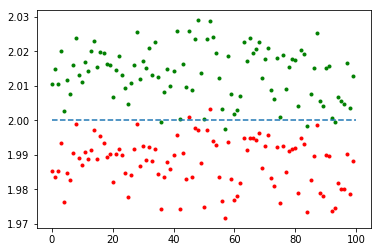

In [83]:
u = stat.norm.ppf(0.975)
count = 0
for T in range(100):
    (I, sigma2) = AIS_Int(obj_fun, n_sample=1000, n_iter=10, N=10, K=1000)
    e = np.sqrt(sigma2)
    upper = I + u*e
    lower = I - u*e
    plt.plot(T, lower, 'r.', T, upper, 'g.')
    if (lower <= 2 and upper >= 2):
        count += 1
plt.plot([0,100],[2,2],'--')

In [84]:
count

94